# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession

In [2]:
#importing pyspark sql functions and other python libraries
from pyspark.sql.functions import avg, stddev, first,col, concat, desc, explode, lit, min, max, split, udf, isnull,from_unixtime,count,when,asc,desc
from pyspark.sql.types import IntegerType,DateType
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as f
from pyspark.sql import Window

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time

In [3]:
#import ML Libraries
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify CapStone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
# Read in full sparkify dataset
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


### 1. Initial Analysis

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Look the data frame samples in tabular format
pd.DataFrame(df.take(5), columns=df.columns).head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


#### 1.1  Exploring the values of some categoric columns

In [8]:
#account paid status
df.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [9]:
#which pages are visited
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [10]:
#HTTP respond status
df.select("status").distinct().show()
df.groupBy("status").count().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+

+------+------+
|status| count|
+------+------+
|   307| 26430|
|   404|   258|
|   200|259812|
+------+------+



over the 90% of all requests are suceeded.

In [11]:
#which values are in the gender columns
df.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



In [12]:
#exploring the authorization column 
df.select("auth").distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



#### 1.2 Checking the counts and Null or Empty Values

In [13]:
# Number of Records in Data Set
print("The number of all records in the dataset: {}".format(df.count()))

The number of all records in the dataset: 286500


In [14]:
#Explore the min and max values of UserIds
df.agg(min("UserID")).show()
df.agg(max("UserID")).show()

+-----------+
|min(UserID)|
+-----------+
|           |
+-----------+

+-----------+
|max(UserID)|
+-----------+
|         99|
+-----------+



It seems that there are some empty values in the UserID field !


In [15]:
#Checking how many null or empty UserIds
print(f'#UserIds# \n null ids:',df.where(isnull(df['userId'])).count())  
print(f' empty ids:',df.where(df['userId']=='').count())  

#UserIds# 
 null ids: 0
 empty ids: 8346


Eventhough there is no null values, there are 8346 records where userId field is empty(" ") in dataset.

In [16]:
# Number of Unique User Ids
print(f'Number of unique users are:',df.select('userId').distinct().count())

Number of unique users are: 226


In [17]:
#cheking all fields for the null values thorugh the nested sql loop
#reference : https://stackoverflow.com/a/44631639/13076699
df.select([count(when(isnull(col), col)).alias(col) for col in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



It seems that "artist","length", and "song" fields have equal number of Nulls, which may show the same way of pattern in all these columns.

Also, "firstname","gender","lastname", "location","registration", and "userAgent" have also the same number of Nulls

In [18]:
#Checking if any user with firstname has UserID
df.select(["UserId","firstname","gender","lastname","location","registration","userAgent"])\
.filter(isnull(df['firstname'])).distinct().show()

+------+---------+------+--------+--------+------------+---------+
|UserId|firstname|gender|lastname|location|registration|userAgent|
+------+---------+------+--------+--------+------------+---------+
|      |     null|  null|    null|    null|        null|     null|
+------+---------+------+--------+--------+------------+---------+



It turns out the null values for "firstname","gender","lastname","location","registration","userAgent" fields are the rows where UserIds are empty. So, we will drop the rows with empty UserId's then.

In [19]:
#checking in additional circumstances where artist is null
df.filter(isnull(df['artist']) & (df['userId']=='')).groupBy(["artist","length","song","auth","page"]).count().show()
df.filter(isnull(df['artist'])).groupBy(["page"]).count().show(30)

+------+------+----+----------+-------------------+-----+
|artist|length|song|      auth|               page|count|
+------+------+----+----------+-------------------+-----+
|  null|  null|null|Logged Out|               Home| 4339|
|  null|  null|null|     Guest|           Register|   18|
|  null|  null|null|Logged Out|              Error|    5|
|  null|  null|null|     Guest|              About|   14|
|  null|  null|null|     Guest|              Error|    1|
|  null|  null|null|Logged Out|              Login| 3241|
|  null|  null|null|Logged Out|               Help|  249|
|  null|  null|null|     Guest|Submit Registration|    5|
|  null|  null|null|Logged Out|              About|  415|
|  null|  null|null|     Guest|               Help|   23|
|  null|  null|null|     Guest|               Home|   36|
+------+------+----+----------+-------------------+-----+

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|   52|
|    Submit D

It shows that artist and song values are null when "aut" is "Logged Out" or "Guest" and when there is no "NextSong" page

#### 1.3 Cleaning and Formatting the Data Frame

In [20]:
# Delete the records where userIds are empty and create a new dataframe
df_cleaned = df.filter(df['userId']!='')
# filter out log out records
df_cleaned = df_cleaned.filter(df_cleaned['auth']!='Logged Out')

In [21]:
# Definig user functions to get hour, day, month, weekday and formatted data time for the further time based analysis

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S")) #formatted date time


# a mapping to colum with the appropriate function
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday,'time':get_time}

# Adding columns to the dataframe
for newcol, func in funcs.items():
    df_cleaned = df_cleaned.withColumn(newcol, func(df_cleaned.ts))

    


In [22]:
#add new columns: city and state info extracting from location
df_cleaned = df_cleaned.withColumn('city', split(col('location'),',').getItem(0))
df_cleaned = df_cleaned.withColumn('state', split(col('location'),',').getItem(1))

In [23]:
#looking to cleaned data frame
pd.DataFrame(df_cleaned.take(5), columns=df_cleaned.columns).head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,ts,userAgent,userId,hour,day,month,week_day,time,city,state
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,1,10,1,2018-10-01 00:01:57,Bakersfield,CA
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,1,10,1,2018-10-01 00:03:00,Boston-Cambridge-Newton,MA-NH
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,1,10,1,2018-10-01 00:06:34,Bakersfield,CA
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0,1,10,1,2018-10-01 00:06:56,Boston-Cambridge-Newton,MA-NH
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0,1,10,1,2018-10-01 00:11:16,Bakersfield,CA


#### 1.4 Basic EDA on Cleaned Data Frame

+---------+-----+
|     auth|count|
+---------+-----+
|Cancelled|   52|
|Logged In|  225|
+---------+-----+



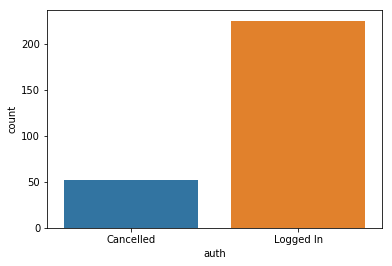

In [24]:
#How many users are cancelled their subscription?
auth_users=df_cleaned.select("auth","userId").distinct().groupBy("auth").count()
auth_users.show()
sns.barplot(x='auth',y='count',data=auth_users.toPandas())

There are 52 users who cancelled their subscription

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



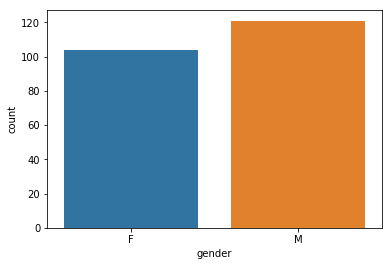

In [25]:
#Unique gender distribution in data set
gender_dist=df_cleaned.select("gender","userId").distinct().groupBy("gender").count()
gender_dist.show()
sns.barplot(x='gender',y='count',data=gender_dist.toPandas())

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



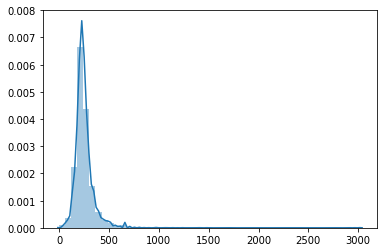

In [26]:
#looking to statistical summary and distribution of the length column
length_data=df_cleaned.select("length").na.drop() 
length_data.describe().show()
sns.distplot(length_data.toPandas())

Event if there are some outliers, the lenght of the data is mainly distributed within 0-500 range. Mean is 249 and standard deviation is 99.2.

In [27]:
level_dist=df_cleaned.select("level","userId").distinct().groupBy("level").count()
level_dist.show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



There are 195 free and 165 paid account in this dataset, it shows that some users have been changed the subscription level during the time duration in dataset. Thus we will evaluate the susbriber final paid level with a new column.

In [28]:
#Finding the users' last level and assignin as a new column as "latest_level" 
df_temp=df_cleaned.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('latest_level'))
df_temp.groupBy("latest_level").count().show()
df_cleaned = df_cleaned.join(df_temp, on='userId')

pd.DataFrame(df_cleaned.take(5), columns=df_cleaned.columns).head(5)

+------------+-----+
|latest_level|count|
+------------+-----+
|        free|   80|
|        paid|  145|
+------------+-----+



,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,ts,userAgent,hour,day,month,week_day,time,city,state,latest_level
0,100010,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",...,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",12,8,10,1,2018-10-08 12:58:54,Bridgeport-Stamford-Norwalk,CT,free
1,100010,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",...,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",13,8,10,1,2018-10-08 13:02:16,Bridgeport-Stamford-Norwalk,CT,free
2,100010,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",...,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",13,8,10,1,2018-10-08 13:05:32,Bridgeport-Stamford-Norwalk,CT,free
3,100010,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",...,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",13,8,10,1,2018-10-08 13:05:33,Bridgeport-Stamford-Norwalk,CT,free
4,100010,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",...,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",13,8,10,1,2018-10-08 13:09:55,Bridgeport-Stamford-Norwalk,CT,free


In [29]:
#Check the city and state distribution of users in dataset
city_dist=df_cleaned.select("city","userId").distinct().groupBy("city").count().orderBy(desc("count"))
state_dist=df_cleaned.select("state","userId").distinct().groupBy("state").count().orderBy(desc("count"))
city_dist.show(5)
state_dist.show(5)

+--------------------+-----+
|                city|count|
+--------------------+-----+
|Los Angeles-Long ...|   16|
|New York-Newark-J...|   15|
|Phoenix-Mesa-Scot...|    7|
|Dallas-Fort Worth...|    7|
|           St. Louis|    6|
+--------------------+-----+
only showing top 5 rows

+---------+-----+
|    state|count|
+---------+-----+
|       CA|   33|
|       TX|   16|
| NY-NJ-PA|   15|
|       FL|   14|
|       AZ|    7|
+---------+-----+
only showing top 5 rows



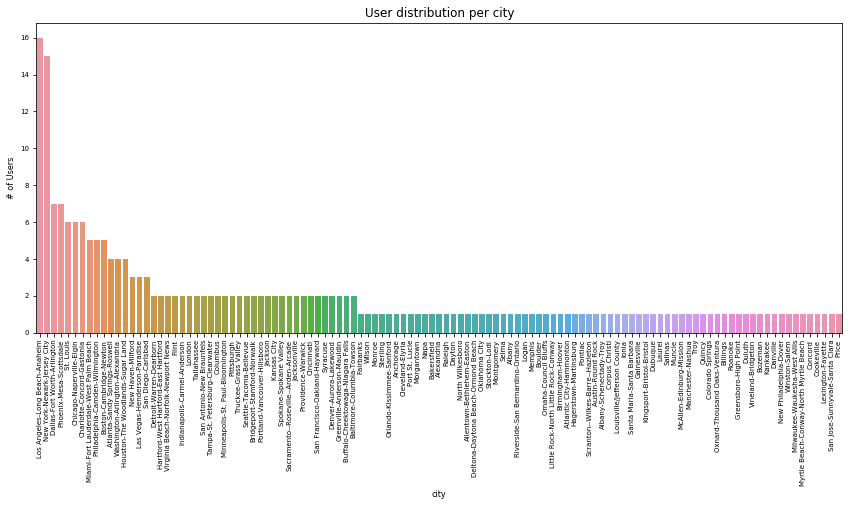

In [30]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x='city',y='count',data=city_dist.toPandas());
ax.axes.set_title("User distribution per city",fontsize=12)
ax.set_xlabel("city",fontsize=8)
ax.set_ylabel("# of Users",fontsize=8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.tick_params(labelsize=7)

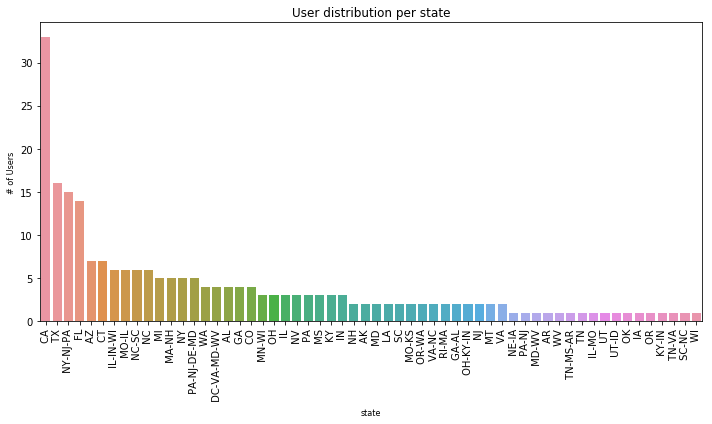

In [31]:
plt.figure(figsize=(10,6))
ax=sns.barplot(x='state',y='count',data=state_dist.toPandas());
ax.axes.set_title("User distribution per state",fontsize=12)
ax.set_xlabel("state",fontsize=8)
ax.set_ylabel("# of Users",fontsize=8)
plt.xticks(rotation=90)
plt.tight_layout()

Los Angeles and New York are top cities which have the largest user count, and California is the top state has the largest user count.

In [32]:
#Check the page distribution in dataset
page_dist=df_cleaned.select("page","userId").groupBy("page").count().orderBy(desc("count"))
page_dist.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



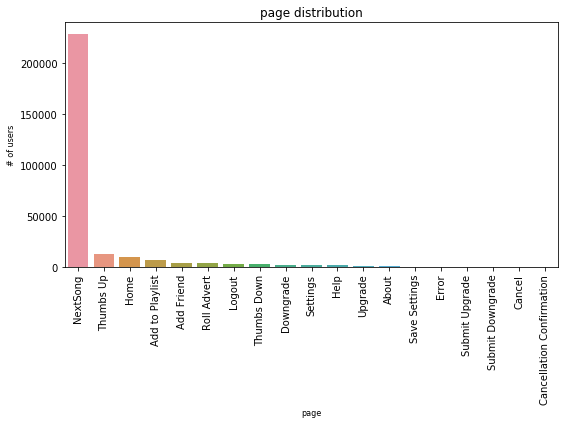

In [33]:
plt.figure(figsize=(8,6))
ax=sns.barplot(x='page',y='count',data=page_dist.toPandas());
ax.axes.set_title("page distribution",fontsize=12)
ax.set_xlabel("page",fontsize=8)
ax.set_ylabel("# of users",fontsize=8)
plt.xticks(rotation=90)
plt.tight_layout()

In [34]:
#User Agent Distribution
useragent_dist=df_cleaned.select("userAgent","userId").distinct().groupBy("userAgent").count().orderBy(desc("count"))
useragent_dist.take(5)

[Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', count=24),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', count=18),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', count=16),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', count=12),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', count=12)]

In [35]:
#Reference for checking: https://developers.whatismybrowser.com/useragents/parse/

#Basic grouping type of browser based on the UserAgent value
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [36]:
# Definig user functions to extract browser information
browser = udf(lambda x : get_browser(x))
df_cleaned=df_cleaned.withColumn("browser",browser(df_cleaned.userAgent))

In [37]:
#Browser distribution
useragent_dist=df_cleaned.select(["userId","browser"]).toPandas()  # change to pandas dataframe
useragent_dist.groupby('browser').count().sort_values("userId")

,userId
browser,
IE,15347
Firefox,55646
Safari,61570
Chrome,145591


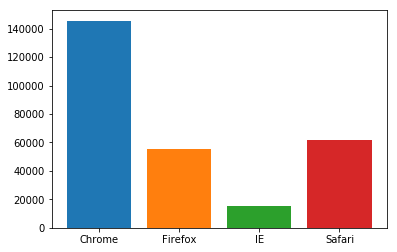

In [38]:
x_temp=useragent_dist.groupby('browser').count()
plt.bar(x_temp.index.values, x_temp["userId"], color=['C0', 'C1', 'C2', 'C3'])
plt.show()

The chrome browser is dominantly used within users.

In [39]:
#Using only time related columns by creasing a new data frame
time_data=df_cleaned.select("userId","time","day","hour","week_day").toPandas()
time_data.head()

,userId,time,day,hour,week_day
0,100010,2018-10-08 12:58:54,8,12,1
1,100010,2018-10-08 13:02:16,8,13,1
2,100010,2018-10-08 13:05:32,8,13,1
3,100010,2018-10-08 13:05:33,8,13,1
4,100010,2018-10-08 13:09:55,8,13,1


In [40]:
time_data.dtypes

userId      object
time        object
day         object
hour        object
week_day    object
dtype: object

In [41]:
#Converting time to date dtype
time_data['time'] = pd.to_datetime(time_data['time'])

In [42]:
#create weekday name 
#Ref: https://stackoverflow.com/a/29096827/13076699
time_data['week_day_name']=time_data['time'].dt.day_name()

In [43]:
time_data.head()

,userId,time,day,hour,week_day,week_day_name
0,100010,2018-10-08 12:58:54,8,12,1,Monday
1,100010,2018-10-08 13:02:16,8,13,1,Monday
2,100010,2018-10-08 13:05:32,8,13,1,Monday
3,100010,2018-10-08 13:05:33,8,13,1,Monday
4,100010,2018-10-08 13:09:55,8,13,1,Monday


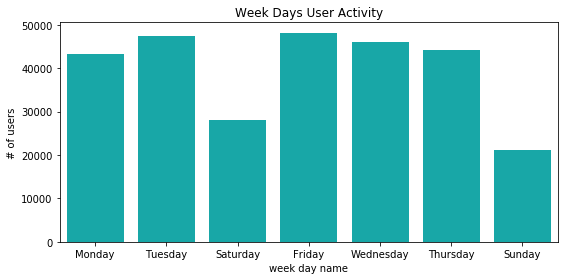

In [44]:
#Checking the daily cycle distribution in a week
week_data=time_data.groupby("week_day_name",sort=False)['userId'].count().reset_index()

plt.figure(figsize=(8,4))
ax=sns.barplot(x='week_day_name',y='userId',data=week_data,color="c");
ax.axes.set_title("Week Days User Activity",fontsize=12)
ax.set_xlabel("week day name",fontsize=10)
ax.set_ylabel("# of users",fontsize=10)
plt.tight_layout()

We may say that users are using the app more offten in workdays than weekend

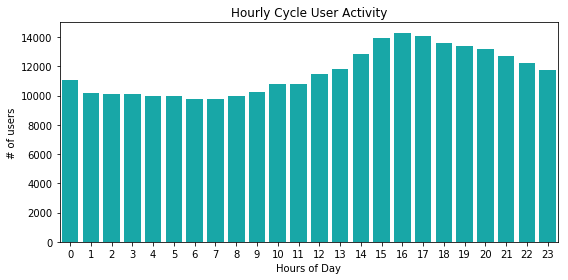

In [45]:
#Checking hourly cycle in a day
time_data['hour']=time_data['hour'].astype(int)
data_hour=time_data.groupby("hour")['userId'].count().reset_index()

plt.figure(figsize=(8,4))
ax=sns.barplot(x='hour',y='userId',data=data_hour,color="c");
ax.axes.set_title("Hourly Cycle User Activity",fontsize=12)
ax.set_xlabel("Hours of Day",fontsize=10)
ax.set_ylabel("# of users",fontsize=10)
plt.tight_layout()

In one single day, the users use sparkify more often after 14 o'clock.

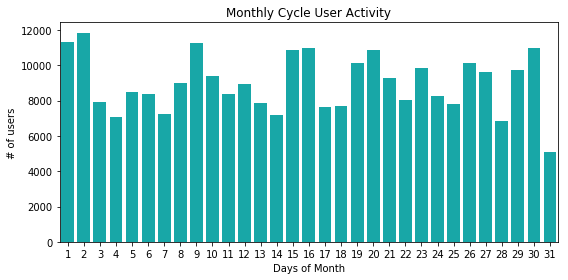

In [46]:
#Checking daily activity in a month
time_data['day']=time_data['day'].astype(int)
data_day=time_data.groupby("day")['userId'].count().reset_index()

plt.figure(figsize=(8,4))
ax=sns.barplot(x='day',y='userId',data=data_day,color="c");
ax.axes.set_title("Monthly Cycle User Activity",fontsize=12)
ax.set_xlabel("Days of Month",fontsize=10)
ax.set_ylabel("# of users",fontsize=10)
plt.tight_layout()

There is no spesific acitivy that we may draw from in a monthly manner


### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [47]:
#We will define a column named Churn as dataset's label for predict
#the cancellation info is provided under the page columns
df_cleaned.select('page').distinct().show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [48]:
# Defining a udf function for labeling churn with  to transform event to 0 or 1
flag_churn_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [49]:
#define the current churn or not state
df_cleaned = df_cleaned.withColumn('churn_state',flag_churn_event('page'))

In [50]:
#Define window range through the window function
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [51]:
#mark the user who have churned event
df_cleaned = df_cleaned.withColumn("churn", Fsum("churn_state").over(windowval))

In [52]:
#Take a look to the data frame with the churn labels
pd.DataFrame(df_cleaned.take(5), columns=df_cleaned.columns).head(5)

,userId,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,day,month,week_day,time,city,state,latest_level,browser,churn_state,churn
0,100010,None,Logged In,Darianna,F,34,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",...,21,11,3,2018-11-21 18:12:32,Bridgeport-Stamford-Norwalk,CT,free,Safari,0,0
1,100010,Lily Allen,Logged In,Darianna,F,33,Carpenter,185.25995,free,"Bridgeport-Stamford-Norwalk, CT",...,21,11,3,2018-11-21 18:12:31,Bridgeport-Stamford-Norwalk,CT,free,Safari,0,0
2,100010,John Waite,Logged In,Darianna,F,32,Carpenter,269.76608,free,"Bridgeport-Stamford-Norwalk, CT",...,21,11,3,2018-11-21 18:08:02,Bridgeport-Stamford-Norwalk,CT,free,Safari,0,0
3,100010,Hermano,Logged In,Darianna,F,31,Carpenter,115.90485,free,"Bridgeport-Stamford-Norwalk, CT",...,21,11,3,2018-11-21 18:06:07,Bridgeport-Stamford-Norwalk,CT,free,Safari,0,0
4,100010,None,Logged In,Darianna,F,30,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",...,21,11,3,2018-11-21 18:00:57,Bridgeport-Stamford-Norwalk,CT,free,Safari,0,0


In [53]:
df_cleaned.select(["churn","userId"]).distinct().groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



There are 52 users who have been churned... Almost 23% of users have been churned for the given dataset.

### 2. Analysis  based on the each stage of churn:

In [54]:
#gender distribution for active and churn users
df_cleaned.select(["churn","userId","gender"]).distinct().groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    0|     M|   89|
|    1|     M|   32|
|    1|     F|   20|
+-----+------+-----+



The churn rate for the Males and Femals are 26.4% and 19.2%.

In [55]:
#checking the paid status between churn and active users
df_cleaned.select(["churn","userId","latest_level"]).distinct().groupby(["churn", "latest_level"]).count().sort("churn").show()

+-----+------------+-----+
|churn|latest_level|count|
+-----+------------+-----+
|    0|        free|   59|
|    0|        paid|  114|
|    1|        paid|   31|
|    1|        free|   21|
+-----+------------+-----+



The churn rate for the paid and free subscriptions are around 21.4% and 26.3%. They is a slight difference on the level status

In [99]:
#Churn ratio for among all pages
c1=df_cleaned.select("churn","page","userId").where((df_cleaned.churn == 1) & (df_cleaned.page != "NextSong")).groupBy('page').count()
c2=df_cleaned.select("churn","page","userId").where((df_cleaned.churn == 0) & (df_cleaned.page != "NextSong")).groupBy('page').count()

#calculate the percentage of churners and active users for each page
churn_user_activity= c1.withColumn('churn_users', f.col('count')*100/f.sum('count').over(Window.partitionBy()))
non_churn_user_activity= c2.withColumn('active_users', f.col('count')*100/f.sum('count').over(Window.partitionBy()))


In [112]:
def percent_melt_df(col):
    
    #Churn ratio for among all pages
    c1=df_cleaned.select("churn",col,"userId").where(df_cleaned.churn == 1).groupBy(col).count()
    c2=df_cleaned.select("churn",col,"userId").where(df_cleaned.churn == 0).groupBy(col).count()

    #calculate the percentage of churners and active users for each page
    churn_user_activity= c1.withColumn('churn_users', f.col('count')*100/f.sum('count').over(Window.partitionBy()))
    non_churn_user_activity= c2.withColumn('active_users', f.col('count')*100/f.sum('count').over(Window.partitionBy()))
    
    #Joining the churners and active users in a one dataframe
    ta = churn_user_activity.alias('ta')
    tb = non_churn_user_activity.alias('tb')
    churn_percentile_df=ta.join(tb, ta[col] == tb[col]).select([ta[col],"active_users","churn_users"]).toPandas()
    if col=="page":
        churn_percentile_df=churn_percentile_df[churn_percentile_df["page"]!="NextSong"]

    melt_df = churn_percentile_df.melt(id_vars=col)
    return melt_df

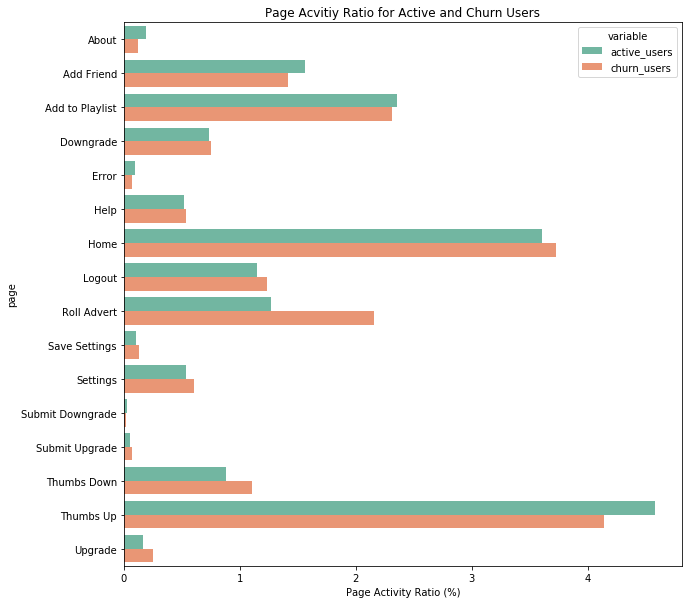

In [113]:
#Plotting churn and active users based on the page usage percentile
fig, ax = plt.subplots(figsize=(10, 10))
melt_df= percent_melt_df("page")
sns.barplot(y='page', x='value', hue='variable', data=melt_df, ax=ax,orient="h", palette="Set2")
ax.set_xlabel('Page Activity Ratio (%)')
ax.set_title('Page Acvitiy Ratio for Active and Churn Users');


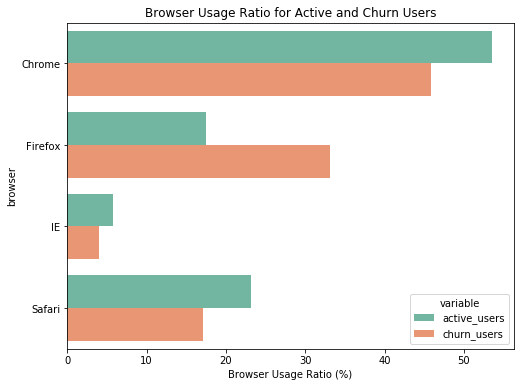

In [116]:

#Plotting churn and active users based on the browser usage percentile
fig, ax = plt.subplots(figsize=(8, 6))
melt_df= percent_melt_df("browser")
sns.barplot(y='browser', x='value', hue='variable', data=melt_df, ax=ax,orient="h", palette="Set2")
ax.set_xlabel('Browser Usage Ratio (%)')
ax.set_title('Browser Usage Ratio for Active and Churn Users');

we observe that the majority of users use Chrome, whereas the churn rate is higher for the FireFox Users as shown below.

### 2.1 Timely behavioural change between Churn and Active Users

In [61]:
# for easy manupulation and plotting, converting spark data frame to pandas_dataframe
df_pandas=df_cleaned.toPandas()

In [62]:
def plotting_time(coln, title=None):
    '''
     a bar plot for churn and active users based on a specific column (hour, day, etc)
    '''
    
    #Churn customer series 
    churn_s =df_pandas[df_pandas["churn"]==1]
    churn_s=churn_s.groupby(coln)['userId'].count()
    
    #active customer series
    active_s =df_pandas[df_pandas["churn"]==0]
    active_s=active_s.groupby(coln)['userId'].count()
    
    #create data_frame of active and churn users
    df_time = pd.DataFrame({'Churn Users':churn_s, "Active Users":active_s})
    
    #create a ratio within each series
    norm_df=df_time/df_time.sum()*100
    
    norm_df=norm_df.reset_index()
    norm_df[coln]=norm_df[coln].astype(int)
    tidy = norm_df.melt(id_vars=coln)
    
    fig, ax1 = plt.subplots(figsize=(14, 4))
    ax1=sns.barplot(x=coln, y='value', hue='variable', data=tidy, palette='Blues')
    
    ax1.set_ylabel('Ratio of Users')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
    ax1.set_title(f'Ratio of Users Acivity per {title}') 
    return ax1

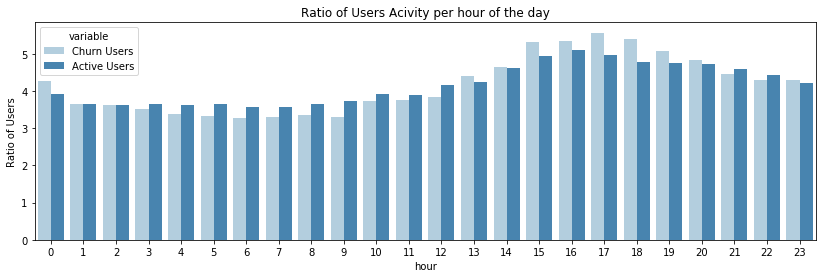

In [63]:
plotting_time('hour', title='hour of the day')

It appears that no visual effect of difference between remaining and churn users according to hour of the day. The only effect is that the churn users are more active on the time between 13:00 to 20:00

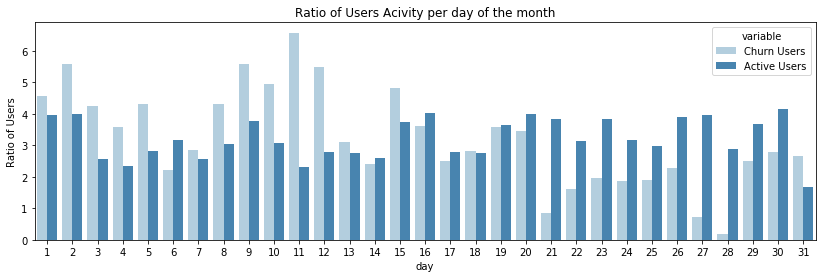

In [64]:
plotting_time('day', title='day of the month')

Most cancellation happens at the end of the month, which is logical to avoid renewal fees.

[Text(0,0,'Mon'),
 Text(0,0,'Tue'),
 Text(0,0,'Wed'),
 Text(0,0,'Thu'),
 Text(0,0,'Fri'),
 Text(0,0,'Sat'),
 Text(0,0,'Sun')]

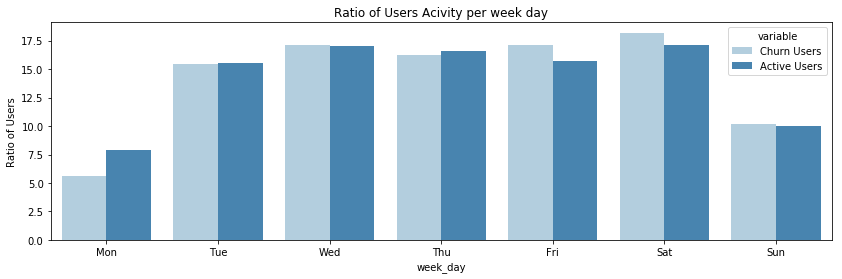

In [65]:
ax = plotting_time('week_day', title='week day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

There is  slight differentiation on Friday, Saturday and Monday between Churn and Active Users.

The remaining days have no noticable difference between user's types.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### 3. Feature Creations

In [120]:
#check the columns data types
df_cleaned.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- week_day: string (nullable = true)
 |-- time: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latest_level: string (nullable = true)
 |-- 

#### On the basis of the above EDA, we can create features as follows:

- Categorical Features
    - The gender of user
    - The payment level (Paid/Free)
    - The Browser

- Numerical Features
    - mean,max,min,std of length of users
    - numbers of these item in page (NextSong,ThumbsUp, ThumbsDown, AddtoPlaylist, AddFriend, RollAdvert)
    - number of unique songs and total songs of users
    - number of unique artists of users
    - percentage of operations after 15th in a month
    - percentage of operations in workday

### 3.1 Categorical Features

In [121]:
#features: 1-3

#Categorical to Numeric features through the String Indexer
#Reference: https://stackoverflow.com/q/36942233/13076699

indexers = [StringIndexer(inputCol=col, outputCol=col+"Index").fit(df_cleaned) for col in list(["gender","latest_level","browser"])]
pipeline = Pipeline(stages=indexers)

categorical_features=pipeline.fit(df_cleaned)\
                             .transform(df_cleaned)\
                             .select(["userId","genderIndex","latest_levelIndex","browserIndex"]).distinct().sort("userId")


In [122]:
categorical_features.show(3)

+------+-----------+-----------------+------------+
|userId|genderIndex|latest_levelIndex|browserIndex|
+------+-----------+-----------------+------------+
|    10|        1.0|              0.0|         0.0|
|   100|        1.0|              0.0|         2.0|
|100001|        0.0|              1.0|         0.0|
+------+-----------+-----------------+------------+
only showing top 3 rows



### 3.2 Numerical Features

In [123]:
#features: 4-7
#length
feature_length = df_cleaned.select(["userId", "length"]).groupby(["userId"])\
                                                .agg(avg('length').alias('avg_length'), 
                                                     stddev('length').alias('stdev_length'),
                                                     max('length').alias('max_length'),
                                                     min('length').alias('min_length')).sort("userId")

In [124]:
feature_length.show(3)
feature_length.count()

+------+------------------+------------------+----------+----------+
|userId|        avg_length|      stdev_length|max_length|min_length|
+------+------------------+------------------+----------+----------+
|    10|247.94408991084703|   87.304446168749|   978.442|  54.38649|
|   100|250.88659828113387|104.76437749593745|2520.99873|  21.91628|
|100001|263.71234699248123|100.81745802320421| 655.77751|  48.19546|
+------+------------------+------------------+----------+----------+
only showing top 3 rows



225

In [125]:
#features: 8-14

#count the each page
page_count = df_cleaned.select(["userId","page"]).groupby(["userId","page"]).count()

# reshape the data frame with creating the pivot table
temp = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)

# filter insterested columns
temp = temp.select(['userId','NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert']).sort("userId")

# column names used to sum up for total
cols = temp.columns[1:]

# calculate the total 
feature_page = temp.withColumn('total_page', sum([col(c) for c in cols]))

In [126]:
feature_page.show(3)
feature_page.count()

+------+--------+---------+-----------+---------------+----------+-----------+----------+
|userId|NextSong|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert|total_page|
+------+--------+---------+-----------+---------------+----------+-----------+----------+
|    10|     673|       37|          4|              9|        12|          1|       736|
|   100|    2682|      148|         27|             61|        49|         25|      2992|
|100001|     133|        8|          2|              3|         2|         14|       162|
+------+--------+---------+-----------+---------------+----------+-----------+----------+
only showing top 3 rows



225

In [127]:
#features: 15

#unique songs number
feature_nunique_songs = df_cleaned.filter(df_cleaned.page=='NextSong').select(["userId","song"]).\
                                             dropDuplicates(["userId","song"]).groupby(["userId"]).count().sort("userId")

feature_nunique_songs=feature_nunique_songs.withColumnRenamed("count", "num_unique_song")

In [128]:
feature_nunique_songs.show(3)
feature_nunique_songs.count()

+------+---------------+
|userId|num_unique_song|
+------+---------------+
|    10|            629|
|   100|           2302|
|100001|            129|
+------+---------------+
only showing top 3 rows



225

In [129]:
#features: 16
#total songs number
feature_ntotal_songs = df_cleaned.filter(df_cleaned.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count().sort("userId")

feature_ntotal_songs = feature_ntotal_songs.withColumnRenamed("count", "ntotal_song")

In [130]:
feature_ntotal_songs.show(3)
feature_ntotal_songs.count()

+------+-----------+
|userId|ntotal_song|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
+------+-----------+
only showing top 3 rows



225

In [131]:
#features: 17
#unique artists nunber
feature_nunique_artists = df_cleaned.filter(df_cleaned.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count().sort("userId")
feature_nunique_artists = feature_nunique_artists.withColumnRenamed("count", "nunique_artist")

In [132]:
feature_nunique_artists.show(3)
feature_nunique_artists.count()

+------+--------------+
|userId|nunique_artist|
+------+--------------+
|    10|           565|
|   100|          1705|
|100001|           125|
+------+--------------+
only showing top 3 rows



225

In [133]:
#percentage of operations over the day and weekdays
day_count = df_cleaned.filter(df_cleaned.day>=15).select(['userId']).groupby(["userId"]).count() # number of days greater more than half ot a month
day_count = day_count.withColumnRenamed("count", "day_count")

total_count = df_cleaned.select(['userId']).groupby(["userId"]).count()
total_count = total_count.withColumnRenamed("count", "total_count")

weekday_count = df_cleaned.filter(df_cleaned.week_day<5).select(['userId']).groupby(["userId"]).count() # number of days in weekdays
weekday_count = weekday_count.withColumnRenamed("count", "weekday_count")

In [134]:
#features: 18-19
feature_percentage_month = (total_count.alias("t1").join(day_count.alias("t2"), ["userId"]).\
                              select(col("userId"), (col("t2.day_count") / col("t1.total_count")).alias("month_percentage"))).sort("userId")
    
feature_percentage_week = (total_count.alias("t1").join(weekday_count.alias("t2"), ["userId"]).\
                          select(col("userId"), (col("t2.weekday_count") / col("t1.total_count")).alias("week_percentage"))).sort("userId")

In [135]:
feature_percentage_month.show(3)
feature_percentage_week.show(3)
feature_percentage_month.count()
feature_percentage_week.count()


+------+-------------------+
|userId|   month_percentage|
+------+-------------------+
|    10| 0.8138364779874214|
|   100| 0.5634723086496577|
|100002|0.26146788990825687|
+------+-------------------+
only showing top 3 rows

+------+------------------+
|userId|   week_percentage|
+------+------------------+
|    10|0.7610062893081762|
|   100|0.9231487243310517|
|100001|               1.0|
+------+------------------+
only showing top 3 rows



219

### 3.3 Merging and Saving All Features Data Frame

In [136]:
#merge all 7 numerical features together
numerical_features = feature_length.\
                        join(feature_page,on='userId',how='inner').\
                        join(feature_nunique_songs,on='userId',how='inner').\
                        join(feature_ntotal_songs,on='userId',how='inner').\
                        join(feature_nunique_artists,on='userId',how='inner').\
                        join(feature_percentage_month,on='userId',how='outer').\
                        join(feature_percentage_week,on='userId',how='outer').sort("userId")

numerical_features = numerical_features.na.fill(0)

In [137]:
numerical_features.show(3)

+------+------------------+------------------+----------+----------+--------+---------+-----------+---------------+----------+-----------+----------+---------------+-----------+--------------+------------------+------------------+
|userId|        avg_length|      stdev_length|max_length|min_length|NextSong|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert|total_page|num_unique_song|ntotal_song|nunique_artist|  month_percentage|   week_percentage|
+------+------------------+------------------+----------+----------+--------+---------+-----------+---------------+----------+-----------+----------+---------------+-----------+--------------+------------------+------------------+
|    10|247.94408991084703|   87.304446168749|   978.442|  54.38649|     673|       37|          4|              9|        12|          1|       736|            629|        673|           565|0.8138364779874214|0.7610062893081762|
|   100|250.88659828113387|104.76437749593745|2520.99873|  21.91628|    2682

In [138]:
#Join "Churn" labels, Categorical and Numerical features as a dataframe
label = df_cleaned.select(['userId','churn']).dropDuplicates()

df_all_features = categorical_features\
                 .join(numerical_features,on='userId',how='inner')\
                 .join(label,on='userId',how='inner').sort("userId")\

In [139]:
df_all_features.show(3)

+------+-----------+-----------------+------------+------------------+------------------+----------+----------+--------+---------+-----------+---------------+----------+-----------+----------+---------------+-----------+--------------+------------------+------------------+-----+
|userId|genderIndex|latest_levelIndex|browserIndex|        avg_length|      stdev_length|max_length|min_length|NextSong|Thumbs Up|Thumbs Down|Add to Playlist|Add Friend|Roll Advert|total_page|num_unique_song|ntotal_song|nunique_artist|  month_percentage|   week_percentage|churn|
+------+-----------+-----------------+------------+------------------+------------------+----------+----------+--------+---------+-----------+---------------+----------+-----------+----------+---------------+-----------+--------------+------------------+------------------+-----+
|    10|        1.0|              0.0|         0.0|247.94408991084703|   87.304446168749|   978.442|  54.38649|     673|       37|          4|              9|  

In [140]:
#backing up all results for later use
df_all_features.write.mode("overwrite").save('df_final.json',format='json',header=True)

In [141]:
#load from backup file
df_final = spark.read.json('df_final.json')

In [142]:
df_final.columns

['Add Friend',
 'Add to Playlist',
 'NextSong',
 'Roll Advert',
 'Thumbs Down',
 'Thumbs Up',
 'avg_length',
 'browserIndex',
 'churn',
 'genderIndex',
 'latest_levelIndex',
 'max_length',
 'min_length',
 'month_percentage',
 'ntotal_song',
 'num_unique_song',
 'nunique_artist',
 'stdev_length',
 'total_page',
 'userId',
 'week_percentage']

In [143]:
#define categorical and numerical columns from loaded data
categorical_cols = ['genderIndex','browserIndex','latest_levelIndex']
numerical_cols = list(set([col_name for col_name in df_final.columns if col_name not in categorical_cols])-set(["userId","churn"]))
feature_cols=numerical_cols + categorical_cols

In [144]:
df_final.printSchema()
print(f"Features are:" ,feature_cols)

root
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Thumbs Down: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- avg_length: double (nullable = true)
 |-- browserIndex: double (nullable = true)
 |-- churn: long (nullable = true)
 |-- genderIndex: double (nullable = true)
 |-- latest_levelIndex: double (nullable = true)
 |-- max_length: double (nullable = true)
 |-- min_length: double (nullable = true)
 |-- month_percentage: double (nullable = true)
 |-- ntotal_song: long (nullable = true)
 |-- num_unique_song: long (nullable = true)
 |-- nunique_artist: long (nullable = true)
 |-- stdev_length: double (nullable = true)
 |-- total_page: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- week_percentage: double (nullable = true)

Features are: ['min_length', 'max_length', 'week_percentage', 'Roll Advert', 'Thumbs Up', 'ntotal_song', '

### 3.4 Pre-processing Data

In [145]:
#implement standscaler
#vector Assembler and Standardize features by removing the mean and scaling to unit variance
assembler = VectorAssembler(inputCols=list(feature_cols), outputCol='features')

temp = assembler.transform(df_final)
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')

#The scaled version of the dataframe
scaled_inputs = scaler.fit(temp).transform(temp)


In [146]:
scaled_inputs.select("churn","features","features_scaled").show(3)

+-----+--------------------+--------------------+
|churn|            features|     features_scaled|
+-----+--------------------+--------------------+
|    0|[27.01016,2520.99...|[0.75243368105073...|
|    0|[11.93751,2520.99...|[0.33254836668423...|
|    0|[11.93751,2015.79...|[0.33254836668423...|
+-----+--------------------+--------------------+
only showing top 3 rows



In [147]:
# Select the output and input features
model_data = scaled_inputs.select(scaled_inputs.churn.alias('label'), scaled_inputs.features_scaled.alias('features'))

In [156]:
model_data.take(2)

[Row(label=0, features=DenseVector([0.7524, 3.5243, 3.0784, 0.232, 1.8938, 2.3349, 1.8352, 41.7345, 2.4682, 2.679, 1.9562, 2.3349, 2.2938, 2.4744, 5.5587, 2.0406, 2.0013, 2.0816, 0.0])),
 Row(label=0, features=DenseVector([0.3325, 3.5243, 2.7763, 3.9443, 4.4595, 5.3803, 5.5056, 42.223, 2.078, 4.8083, 5.5324, 5.3803, 5.4012, 5.1563, 5.7991, 5.3445, 0.0, 1.0408, 2.0844]))]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [149]:
def fit_predict(train, test, model):
    '''
    Fits and runs predictions with given Spark training and test data
    
    train : training data
    test  : testing data
    model : model name 
    :return 
    '''
    
    #Train the model
    clf = model.fit(train)
    
    #predictions
    predict_data = clf.transform(test)
    model_name=str(model).split("_", 1)[0]
    print("\n",model_name +" Model:")
    evaluate_model(predict_data)    
      
    return clf, predict_data


In [150]:
def evaluate_model(predict_data):
    '''
    Runs output evaluator on the prediction results
    
    results: Spark DataFrame, model prediction outputs
    return None
    '''
     
    evaluator = MulticlassClassificationEvaluator()
    auc_evaluator = BinaryClassificationEvaluator()
    f1_score = evaluator.evaluate(predict_data.select(col('label'), col('prediction')),{evaluator.metricName : "f1"})
    accuracy_score= evaluator.evaluate(predict_data.select(col('label'), col('prediction')),{evaluator.metricName : "accuracy"})
    
    auc_value = auc_evaluator.evaluate(predict_data, {auc_evaluator.metricName: "areaUnderROC"})
        
    print(' The F1 score is {:.2%}'.format(f1_score)) 
    print(" The accuracy is {:.2%}".format(accuracy_score))    
    print(' The areaUnderROC is {:.2%}'.format(auc_value))

### BaseLine Models

In [151]:
# Defining training and testing samples
train, test = model_data.randomSplit([0.8, 0.2],seed=7)

In [152]:
# Fit various models and get their accuracies with the default parameters
Models=[LogisticRegression(),RandomForestClassifier(),LinearSVC(),GBTClassifier(),DecisionTreeClassifier(),NaiveBayes()]
#Models=[GBTClassifier()]
for model in Models:
    fit_predict(train, test, model)


 LogisticRegression Model:
 The F1 score is 82.11%
 The accuracy is 85.42%
 The areaUnderROC is 66.32%

 RandomForestClassifier Model:
 The F1 score is 76.99%
 The accuracy is 81.25%
 The areaUnderROC is 66.84%

 LinearSVC Model:
 The F1 score is 69.96%
 The accuracy is 79.17%
 The areaUnderROC is 63.68%

 GBTClassifier Model:
 The F1 score is 81.67%
 The accuracy is 83.33%
 The areaUnderROC is 62.89%

 DecisionTreeClassifier Model:
 The F1 score is 76.63%
 The accuracy is 77.08%
 The areaUnderROC is 49.47%

 NaiveBayes Model:
 The F1 score is 67.38%
 The accuracy is 64.58%
 The areaUnderROC is 61.05%


Selecting the classifier
Comparing the F-1 score and accuracy of among the classifiers, we see that Logistic Regression has the highest score. I will select this classifier for the next step: Tuning model

### Tuning 
##### Logistic Regression Model

In [185]:
# Tuning Hyperparameters for the LogisticRegression model using Grid Search
lr= LogisticRegression()

paramGrid = ParamGridBuilder()\
                .addGrid(lr.regParam, [0.3, 0.1, 0.01])\
                .addGrid(lr.elasticNetParam, [0.3,0.8,1.0])\
                .addGrid(lr.maxIter, [5,10,15])\
                .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

#Train the model
cvModel = crossval.fit(train)


#predict model on the test data set
predictions = cvModel.transform(test)

#Evaluate Model Prediction Results
evaluate_model(predictions)


 The F1 score is 78.57%
 The accuracy is 83.33%
 The areaUnderROC is 63.16%


In fact, we could not get outperformed our Logistic Regression results with default parameters, thus we keep base Logistic Regression Model for the final Model.

In [186]:
#LogisticRegression model with default parameters
final_model= LogisticRegression()
clf, predict_data=fit_predict(train, test, final_model)



 LogisticRegression Model:
 The F1 score is 82.11%
 The accuracy is 85.42%
 The areaUnderROC is 66.32%


In [188]:
#Find the best parameters
print('Best parameters : regParam:{}, elasticNetParam:{},maxIter:{}'.\
    format(clf.getOrDefault('regParam'),clf.getOrDefault('elasticNetParam'),clf.getOrDefault('maxIter')))

Best parameters : regParam:0.0, elasticNetParam:0.0,maxIter:100


In [189]:
clf.coefficients.toArray()

array([-0.2639066 ,  0.70356418, -0.39745721,  0.23171622, -1.84104177,
        0.00972981,  0.29842908,  0.09840786, -0.82540522, -0.3017112 ,
        1.56059366,  0.00972981, -0.04348205, -0.02822016, -0.36584544,
       -1.24923551,  0.26781465,  0.04938195, -0.42237395])

#### Analysing the Feature Importances

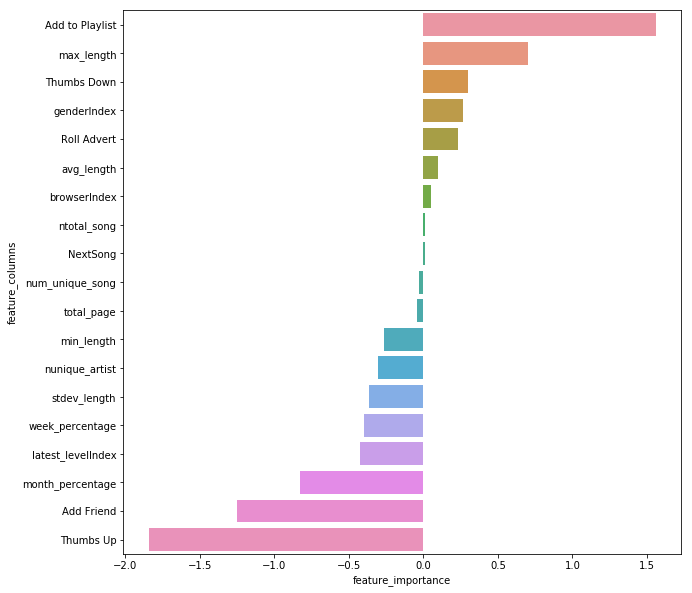

In [190]:
fig, ax = plt.subplots(figsize=(10, 10))
feature_importances = list(clf.coefficients.toArray())
feature_importance_df = pd.DataFrame({'feature_importance': feature_importances, 'feature_columns': feature_cols}).sort_values("feature_importance",ascending=False)
sns.barplot(x='feature_importance', y='feature_columns', data=feature_importance_df)

The most important 3 features "count of thumbs up" and "Add Friend" ,"Add to Playlits" play significantly on prediction user churn.


### Conclusion
To sum up the project , we execute the following steps:

1. Load the dataset into Apache Spark and made a initial anaysis to clean and formatting the dataset
2. Define the Churn and did basic EDA on the cleaned data frame for the possible feature selection
3. Categorical and Numerical features have been selected.
4. Pre-processing has been done via scaling and transforming
5. Calculated features have been fed to various type of Machine learning algorithms.
6. Based on the prediction evaluations, selected one of the best performed ML classifier.
7. Fine Tuning on the best performed model to find the best hyperparameters
8. Find and plot the most important features that affect churn predictions



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.